In [25]:
import warnings # Omitir mensajes de advertencia
warnings.filterwarnings("ignore")

In [26]:
# Trabajamos en colab:
from google.colab import drive
drive.mount('/content/drive/')

import os
path = '/content/drive/MyDrive/Colab Notebooks/LessonGH/'
os.chdir(path)

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [27]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import xarray as xr
from scipy import stats

In [28]:
ds = xr.open_dataset(path + 'spi_pisco.nc', decode_times=False)
ds['time'] = pd.date_range('1981-01-01', '2016-12-31', freq = 'M')
ds = ds.sortby('lat')

In [29]:
ds_idx = ds.sel(time=slice('1981','2010'))
ds_idx = ds_idx['spi_1']
ds_idx

<xarray.DataArray 'spi_1' (lat: 198, lon: 133, time: 360)>
[9480240 values with dtype=float64]
Coordinates:
  * time     (time) datetime64[ns] 1981-01-31 1981-02-28 ... 2010-12-31
  * lat      (lat) float32 -18.75 -18.65 -18.55 -18.45 ... 0.65 0.75 0.85 0.95
  * lon      (lon) float32 -81.25 -81.15 -81.05 -80.95 ... -68.25 -68.15 -68.05

In [30]:
oni = pd.read_excel(path + 'ONI.xlsx')
oni['time'] = pd.date_range('1950-01-01', '2021-12-31', freq = 'M')
oni.set_index('time', inplace = True)

In [31]:
oni_idx = oni.loc['1981':'2010']
oni_idx = oni_idx['oni'].to_numpy()

In [32]:
ds_idx.shape

(198, 133, 360)

In [ ]:
m_corr_pearson =np.zeros((len(ds_idx['lat']), len(ds_idx['lon'])), dtype=float)
m_pvalues =np.zeros((len(ds_idx['lat']), len(ds_idx['lon'])), dtype=float)

for ni in range(len(ds_idx['lon'])):
    for nj in range(len(ds_idx['lat'])):
        info = ds_idx.isel(lat=nj, lon=ni).values
        info = np.array(info)
        valid_mask = np.isfinite(info) & np.isfinite(oni_idx)
        valid_info = info[valid_mask]
        valid_oni_idx = oni_idx[valid_mask]
        if len(valid_info) < 2 or len(valid_oni_idx) < 2:
            m_corr_pearson[nj, ni] = np.nan
            m_pvalues[nj, ni] = np.nan
        else:
            r, p = stats.pearsonr(valid_oni_idx, valid_info)
            m_corr_pearson[nj, ni] = r
            m_pvalues[nj, ni] = p

In [ ]:
data_set = xr.Dataset( coords={"lon": (["lon"], ds_idx.lon.data),
                              "lat": (["lat"], ds_idx.lat.data)})

data_set["corr_pearson"] = (["lat", "lon"], m_corr_pearson)
data_set["p_val"] = (["lat", "lon"], m_pvalues)
data_set

In [ ]:
# %%capture
# !pip install cartopy

In [ ]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature

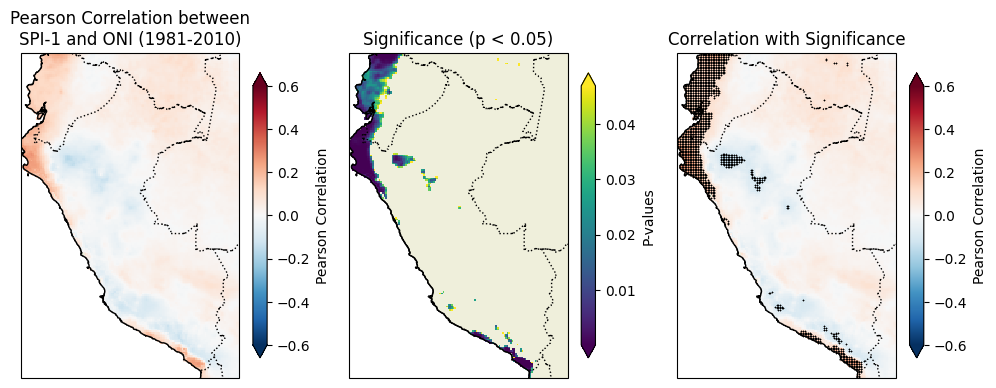

In [41]:
fig, axes = plt.subplots(1, 3, figsize=(10, 6), subplot_kw={'projection': ccrs.PlateCarree()})
data_set.corr_pearson.plot(ax=axes[0], cmap='RdBu_r', vmin=-0.6, vmax=0.6, extend='both', transform=ccrs.PlateCarree(), cbar_kwargs={'label': 'Pearson Correlation', 'shrink': 0.5})
axes[0].set_title('Pearson Correlation between\nSPI-1 and ONI (1981-2010)')
axes[0].add_feature(cfeature.BORDERS, linestyle=':')
axes[0].add_feature(cfeature.COASTLINE)
axes[0].add_feature(cfeature.LAND, edgecolor='black')
pv=data_set.p_val
pv.where(pv < 0.05).plot(ax=axes[1], robust=True, transform=ccrs.PlateCarree(), cbar_kwargs={'label': 'P-values', 'shrink': 0.5})
axes[1].set_title('Significance (p < 0.05)')
axes[1].add_feature(cfeature.BORDERS, linestyle=':')
axes[1].add_feature(cfeature.COASTLINE)
axes[1].add_feature(cfeature.LAND, edgecolor='black')
corr=data_set.corr_pearson
corr.plot(ax=axes[2], cmap='RdBu_r', vmin=-0.6, vmax=0.6, extend='both', cbar_kwargs={'label': 'Pearson Correlation', 'shrink': 0.5})
axes[2].set_title('Correlation with Significance')
for ni in range(pv.shape[1]):
    for nj in range(pv.shape[0]):
        if pv.isel(lat=nj, lon=ni) <= 0.05:
            axes[2].plot(pv.lon[ni].values, pv.lat[nj].values, marker="x", markersize=0.65, color="black")
axes[2].add_feature(cfeature.BORDERS, linestyle=':')
axes[2].add_feature(cfeature.COASTLINE)
axes[2].add_feature(cfeature.LAND, edgecolor='black')
plt.tight_layout()
plt.show()